In [1]:
CALCULATE = False

In [2]:
import os
import numpy as np
np.set_printoptions(suppress=True, formatter={'float': '{:.8f}'.format}, precision=8, linewidth=200)
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0) 
tf.keras.backend.set_floatx('float64')
from matplotlib import pyplot as plt
plt.style.use('default')
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from taskspec.utils_1 import N_sample, tau, ker_eps_rho, n_dim, scale_min, scale, datapath
from taskspec.utils_1 import X_alg, tm
from taskspec.model import ResNet
from taskspec.utils import find_project_root
true_model = tm(tau)
import pandas
import seaborn as sns

2025-05-02 10:42:21.817615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64:
2025-05-02 10:42:21.817643: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
with np.load(f'{datapath}/data/E1_initial.npz') as data:
    initial_tests = data['initial_tests']

In [4]:
def weighted_mse(y_true, y_pred, sample_weight):
    mse = tf.square(y_true - y_pred)
    weighted_mse = tf.reduce_mean(mse * sample_weight)
    return weighted_mse

In [5]:
Nrand = 20
loss_ntr1 = np.zeros((2, 3, Nrand))
loss_ntr2 = np.zeros((2, 3, Nrand))

if CALCULATE:
    for i1, nodes  in enumerate([128, 1024]):
        model = ResNet(n_dim, nodes, tau, scale_min, scale)
        model.build((None, n_dim))
        for i2, N_target in enumerate([25, 50, 100,]):
            for i3, randomseed in enumerate(range(Nrand)):
                    initial_id = randomseed
                    databasename = f'{datapath}/data/data/E1_dr{randomseed}.npz'
                    with np.load(databasename, allow_pickle=True) as data:
                        xdata, ydata = data['xdata'], data['ydata']
                        assert xdata.shape == (N_sample, n_dim)
                        assert ydata.shape == (N_sample, n_dim)
                        rho_train = data['rho_train']
                        assert rho_train.shape == (N_sample, )
                        assert ker_eps_rho == data['ker_eps_rho']

                    initial_test = initial_tests[initial_id][None,:]
                    assert initial_test.shape == (1, n_dim)
                    
                    outputfile = f'{datapath}/weights/weights_ts/E1_t_{nodes}_{N_target}_{randomseed}_{initial_id}.npz'
                    if not os.path.exists(outputfile):
                        print(f"File {outputfile} not found")
                        continue
                    with np.load(outputfile, allow_pickle=True) as data:
                        res = data['res']
                        weights1 = data['weights1']
                        weights_l3 = data['weights_l3']
                        ind_l3 = data['ind_l3']
                        
                    model.set_weights(weights1)
                    traj_true = X_alg(true_model, initial_test, N_target)[:,0]
                    new_sample = X_alg(model, initial_test, N_target)[:,0]
                    
                    with tf.GradientTape() as tape:
                        predictions = model(xdata, training=True)
                        loss = weighted_mse(ydata, predictions, 1)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    gradientnorm = tf.linalg.global_norm(gradients).numpy()
                    print(f'Randomseed {randomseed}; nodes {nodes}; NT {N_target}; Initial cond {initial_id}')
                    print("MSE gradient norm ", gradientnorm)
                    assert gradientnorm < 1e-4
                    
                    # mse
                    model.set_weights(weights1)
                    new_sample = X_alg(model, initial_test, N_target)[:,0]
                    traj_loss1 = np.mean(np.linalg.norm(traj_true - new_sample, axis=-1)[1:])
                    point_loss1 = np.sum(np.square(true_model(new_sample) - model(new_sample)), axis=-1)
                    point_loss1_oo = np.sqrt(np.max(point_loss1))
                    print(f"traj_loss1: {traj_loss1}  point_loss1_oo: {point_loss1_oo}  MSE   ")

                    # l3n
                    model.set_weights(weights_l3)
                    new_sample = X_alg(model, initial_test, N_target)[:,0]
                    traj_loss2 = np.mean(np.linalg.norm(traj_true - new_sample, axis=-1)[1:])
                    point_loss2 = np.sum(np.square(true_model(new_sample) - model(new_sample)), axis=-1)
                    point_loss2_oo = np.sqrt(np.max(point_loss2))
                    print(f"traj_loss2: {traj_loss2}  point_loss2_oo: {point_loss2_oo}  ES  at {ind_l3}  \n")
                    
                    loss_ntr1[i1,i2,i3] = traj_loss1
                    loss_ntr2[i1,i2,i3] = traj_loss2
    np.savez(find_project_root() + "/examples/fig/Eg1.npz", loss_ntr1=loss_ntr1, loss_ntr2=loss_ntr2)
else:
    with np.load(find_project_root() + "/examples/fig/Eg1.npz", allow_pickle=True) as data:
        loss_ntr1 = data['loss_ntr1']
        loss_ntr2 = data['loss_ntr2']

In [6]:
Nrand = 20
loss_ntr = np.zeros((4, Nrand))
loss_rs = np.zeros_like(loss_ntr)

nodes = 128
N_target = 100
model = ResNet(n_dim, nodes, tau, scale_min, scale)
model.build((None, n_dim))

alpha = 0.25

if CALCULATE:
    for randomseed in range(Nrand):
        initial_id = randomseed
        databasename = f'{datapath}/data/data_as/E1_as_dr{alpha}_{randomseed}.npz'
        with np.load(databasename, allow_pickle=True) as data:
            xdata, ydata = data['xdata'], data['ydata']
            assert xdata.shape == (N_sample, n_dim)
            assert ydata.shape == (N_sample, n_dim)
            rho_train = data['rho_train']
            assert rho_train.shape == (N_sample, )
            assert ker_eps_rho == data['ker_eps_rho']
        
        initial_test = initial_tests[initial_id][None,:]
        assert initial_test.shape == (1, n_dim)
        
        weights_rw_file = f'{datapath}/weights/weights_re/E1_re_dr{alpha}_{randomseed}wts.npz'
        assert os.path.exists(weights_rw_file)
        weights_mse = np.load(weights_rw_file, allow_pickle=True)['weights_mse']
        weights1 = np.load(weights_rw_file, allow_pickle=True)['weights1']
        weights2 = np.load(weights_rw_file, allow_pickle=True)['weights2']
        
        outputfile = f'{datapath}/weights/weights_as_ts/E1_as_t_{nodes}_{alpha}_{randomseed}.npz'
        assert os.path.exists(outputfile)    
        with np.load(outputfile, allow_pickle=True) as data:
            res = data['res']
            weights_mse2 = data['weights1']
            weights_l3 = data['weights_l3']
            ind_l3 = data['ind_l3']
        
        model.set_weights(weights_mse)
        traj_true = X_alg(true_model, initial_test, N_target)[:,0]
        new_sample = X_alg(model, initial_test, N_target)[:,0]
        
        with tf.GradientTape() as tape:
            predictions = model(xdata, training=True)
            loss = weighted_mse(ydata, predictions, 1)
        gradients = tape.gradient(loss, model.trainable_variables)
        gradientnorm = tf.linalg.global_norm(gradients).numpy()
        print(f'Randomseed {randomseed}; nodes {nodes}; NT {N_target}; Initial cond {initial_id}')
        print("MSE gradient norm ", gradientnorm)
        
        # mse
        model.set_weights(weights_mse)
        new_sample = X_alg(model, initial_test, N_target)[:,0]
        traj_loss1 = np.mean(np.linalg.norm(traj_true - new_sample, axis=-1)[1:])
        point_loss1 = np.sum(np.square(true_model(new_sample) - model(new_sample)), axis=-1)
        point_loss1_oo = np.sqrt(np.max(point_loss1))
        print(f"traj_loss1: {traj_loss1}  point_loss1_oo: {point_loss1_oo}  MSE   ")
        loss_ntr[0, randomseed] = traj_loss1
        loss_rs[0, randomseed] = point_loss1_oo
        
        # rs 1
        model.set_weights(weights_mse)
        sample_weights1 = 1 / rho_train
        sample_weights1 = sample_weights1 / tf.reduce_mean(sample_weights1)
        
        model.set_weights(weights1)
        with tf.GradientTape() as tape:
            predictions = model(xdata, training=True)
            loss = weighted_mse(ydata, predictions, sample_weights1[:,None])
        gradients = tape.gradient(loss, model.trainable_variables)
        print("Loss", loss.numpy(), "Gradient norm", tf.linalg.global_norm(gradients).numpy())
        new_sample = X_alg(model, initial_test, N_target)[:,0]
        traj_loss1 = np.mean(np.linalg.norm(traj_true - new_sample, axis=-1)[1:])
        point_loss1 = np.sum(np.square(true_model(new_sample) - model(new_sample)), axis=-1)
        point_loss1_oo = np.sqrt(np.max(point_loss1))
        print(f"traj_loss1: {traj_loss1}  point_loss1_oo: {point_loss1_oo}  RW1   ")
        loss_ntr[1, randomseed] = traj_loss1
        loss_rs[1, randomseed] = point_loss1_oo
        
        # rs 2
        model.set_weights(weights_mse)
        sample_weights2 = tf.reduce_mean(tf.square(model(xdata)-ydata), axis=-1)
        sample_weights2 = sample_weights2 / tf.reduce_mean(sample_weights2)
        
        model.set_weights(weights2)
        with tf.GradientTape() as tape:
            predictions = model(xdata, training=True)
            loss = weighted_mse(ydata, predictions, sample_weights2[:,None])
        gradients = tape.gradient(loss, model.trainable_variables)
        print("Loss", loss.numpy(), "Gradient norm", tf.linalg.global_norm(gradients).numpy())
        new_sample = X_alg(model, initial_test, N_target)[:,0]
        traj_loss1 = np.mean(np.linalg.norm(traj_true - new_sample, axis=-1)[1:])
        point_loss1 = np.sum(np.square(true_model(new_sample) - model(new_sample)), axis=-1)
        point_loss1_oo = np.sqrt(np.max(point_loss1))
        print(f"traj_loss1: {traj_loss1}  point_loss1_oo: {point_loss1_oo}  RW2   ")
        loss_ntr[2, randomseed] = traj_loss1
        loss_rs[2, randomseed] = point_loss1_oo
        
        # l3n
        model.set_weights(weights_l3)
        new_sample = X_alg(model, initial_test, N_target)[:,0]
        traj_loss2 = np.mean(np.linalg.norm(traj_true - new_sample, axis=-1)[1:])
        point_loss2 = np.sum(np.square(true_model(new_sample) - model(new_sample)), axis=-1)
        point_loss2_oo = np.sqrt(np.max(point_loss2))
        print(f"traj_loss2: {traj_loss2}  point_loss2_oo: {point_loss2_oo}  ES  at {ind_l3}  \n")                
        loss_ntr[3,randomseed] = traj_loss2
        loss_rs[3, randomseed] = point_loss2_oo
    np.savez(find_project_root() + "/examples/fig/Eg1-4.npz", loss_rs=loss_rs, loss_ntr=loss_ntr)
else:
    with np.load(find_project_root() + "/examples/fig/Eg1-4.npz", allow_pickle=True) as data:
        loss_rs = data['loss_rs']
        loss_ntr = data['loss_ntr']

2025-05-02 10:42:23.442505: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-05-02 10:42:23.509443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 871.81GiB/s
2025-05-02 10:42:23.509857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:51:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 871.81GiB/s
2025-05-02 10:42:23.510152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:8b:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 8

In [7]:
Nrand = 20
loss_ntr13 = np.zeros((1, 5, Nrand))
loss_ntr23 = np.zeros((1, 5, Nrand))
loss_rs13 = np.zeros((1, 5, Nrand))
loss_rs23 = np.zeros((1, 5, Nrand))

if CALCULATE:
    for i1, nodes in enumerate([128]):
        model = ResNet(n_dim, nodes, tau, scale_min, scale)
        model.build((None, n_dim))
        for i2, alpha in enumerate([0.0, 0.25, 0.5, 0.75, 0.99]):
            for i3, randomseed in enumerate(range(Nrand)):
                    initial_id = randomseed
                    databasename = f'{datapath}/data/data_as/E1_as_dr{alpha}_{randomseed}.npz'
                    with np.load(databasename, allow_pickle=True) as data:
                        # print("loading data from", databasename)
                        xdata, ydata = data['xdata'], data['ydata']
                        assert xdata.shape == (N_sample, n_dim)
                        assert ydata.shape == (N_sample, n_dim)
                        rho_train = data['rho_train']
                        assert rho_train.shape == (N_sample, )
                        assert ker_eps_rho == data['ker_eps_rho']

                    initial_test = initial_tests[initial_id][None,:]
                    assert initial_test.shape == (1, n_dim)
                    
                    weights_file = f'{datapath}/weights/weights_as_mse/E1_as_dr{alpha}_{randomseed}_{nodes}wts.npz'
                    if os.path.exists(weights_file):
                        print("Loading", weights_file)
                        weights0 = np.load(weights_file, allow_pickle=True)['weights']
                    
                    outputfile = f'{datapath}/weights/weights_as_ts/E1_as_t_{nodes}_{alpha}_{randomseed}.npz'
                    if not os.path.exists(outputfile):
                        print(f"File {outputfile} not found")
                        continue
                    with np.load(outputfile, allow_pickle=True) as data:
                        res = data['res']
                        weights1 = data['weights1']
                        weights_l3 = data['weights_l3']
                        ind_l3 = data['ind_l3']
                    
                    model.set_weights(weights1)
                    traj_true = X_alg(true_model, initial_test, N_target)[:,0]
                    new_sample = X_alg(model, initial_test, N_target)[:,0]
                    
                    with tf.GradientTape() as tape:
                        predictions = model(xdata, training=True)
                        loss = weighted_mse(ydata, predictions, 1)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    gradientnorm = tf.linalg.global_norm(gradients).numpy()
                    print(f'Randomseed {randomseed}; nodes {nodes}; NT {N_target}; Initial cond {initial_id}')
                    print("MSE gradient norm ", gradientnorm)
                    if gradientnorm > 1e-3:
                        print("Gradient norm too large")
                    
                    # mse
                    model.set_weights(weights1)
                    new_sample = X_alg(model, initial_test, N_target)[:,0]
                    traj_loss1 = np.mean(np.linalg.norm(traj_true - new_sample, axis=-1)[1:])
                    point_loss1 = np.sum(np.square(true_model(new_sample) - model(new_sample)), axis=-1)
                    point_loss1_oo = np.sqrt(np.max(point_loss1))
                    print(f"traj_loss1: {traj_loss1}  point_loss1_oo: {point_loss1_oo}  MSE   ")
                    loss_ntr13[i1,i2,i3] = traj_loss1
                    loss_rs13[i1,i2,i3] = point_loss1_oo                
                    
                    # l3n
                    model.set_weights(weights_l3)
                    new_sample = X_alg(model, initial_test, N_target)[:,0]
                    traj_loss2 = np.mean(np.linalg.norm(traj_true - new_sample, axis=-1)[1:])
                    point_loss2 = np.sum(np.square(true_model(new_sample) - model(new_sample)), axis=-1)
                    point_loss2_oo = np.sqrt(np.max(point_loss2))
                    print(f"traj_loss2: {traj_loss2}  point_loss2_oo: {point_loss2_oo}  ES  at {ind_l3}  \n")                
                    loss_ntr23[i1,i2,i3] = traj_loss2
                    loss_rs23[i1,i2,i3] = point_loss2_oo
    np.savez(find_project_root() + "/examples/fig/Eg1-3.npz", loss_rs1=loss_rs13, loss_rs2=loss_rs23,
             loss_ntr1=loss_ntr13, loss_ntr2=loss_ntr23)
else:
    with np.load(find_project_root() + "/examples/fig/Eg1-3.npz", allow_pickle=True) as data:
        loss_rs13 = data['loss_rs1']
        loss_rs23 = data['loss_rs2']
        loss_ntr13 = data['loss_ntr1']
        loss_ntr23 = data['loss_ntr2']

In [8]:
colors = sns.color_palette("pastel", 10)
colors2 = sns.color_palette("Set3", 30)
colors2[1:3] = [colors2[2], colors2[1]]

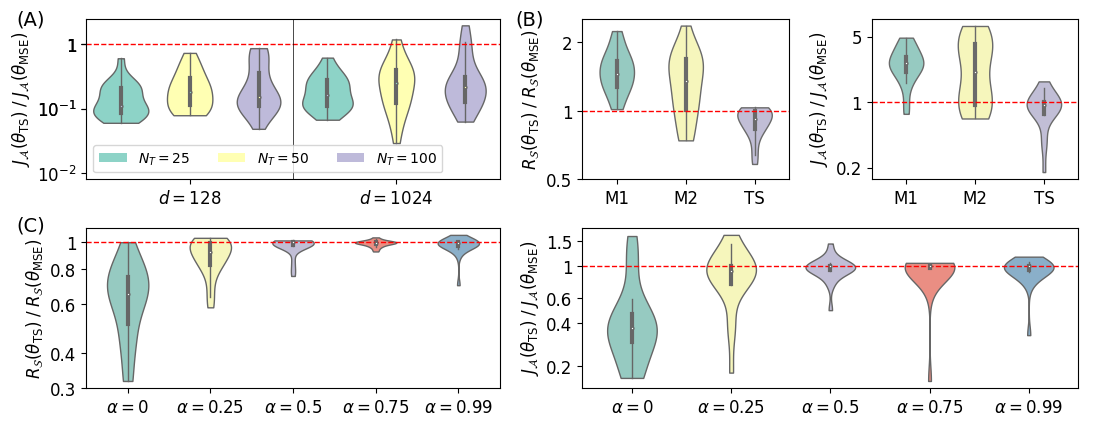

In [9]:
fig = plt.figure(figsize=(6.4*2, 2.4*2)) 
gs = gridspec.GridSpec(2, 3, width_ratios=[0.5, 0.25, 0.25], wspace=0.3, hspace=0.3)

ax1 = fig.add_subplot(gs[0,0])

df = pandas.DataFrame(np.log10(loss_ntr2/loss_ntr1).reshape(-1, loss_ntr2.shape[-1]).T, 
                      columns=[fr'$d=128$' + '\n' +fr'$N_T=25$', 
                               fr'$d=128$' + '\n' +fr'$N_T=50$', 
                               fr'$d=128$' + '\n' +fr'$N_T=100$', 
                               fr'$d=1024$' + '\n' +fr'$N_T=25$', 
                               fr'$d=1024$' + '\n' +fr'$N_T=50$', 
                               fr'$d=1024$' + '\n' +fr'$N_T=100$'])

ax = sns.violinplot(data=df, bw_adjust=.5, cut=0, linewidth=1, palette="Set3", ax=ax1)
for i, violin in enumerate(ax.collections):
    violin.set_facecolor((*colors2[i%3], 1.0))
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  

plt.ylabel(r'$J_{\mathcal{A}}(\theta_{\mathrm{TS}}) \;/\; J_{\mathcal{A}}(\theta_{\mathrm{MSE}})$', fontsize=12)
plt.xlabel(r'', fontsize=12)
plt.xticks([1,4],[fr"$d=128$", fr"$d=1024$"], fontsize=12)
log_ticks = [int(tick) for tick in plt.yticks()[0]]
plt.yticks(log_ticks, [fr"$10^{{{tick}}}$" if tick != 0 else "1" for tick in log_ticks])
plt.tick_params(axis='both', which='major', labelsize=12)

handles = [Patch(facecolor=ax.collections[i*2].get_facecolor()[0], 
                 label=(fr'$N_T={NT}$'))
           for i, NT in enumerate([25, 50, 100])]
plt.ylim([-2.1,0.4])
plt.legend(handles=handles, loc='lower left', ncol=3)
plt.axvline(x=2.5, color='k', linestyle='-', linewidth=0.5)  

ax2 = fig.add_subplot(gs[0,1])

ja = np.log10(loss_rs[1:]/loss_rs[0]).T
df = pandas.DataFrame(ja, columns=["M1", "M2", "TS"])

ax = sns.violinplot(
    data=df, 
    bw_adjust=0.5, 
    cut=0, 
    linewidth=1, 
    palette="Set3", 
    legend=False,
    scale="width",
    width=0.5
)
plt.xlabel("", fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  
plt.ylabel(r'$R_{\mathcal{S}}(\theta_{\mathrm{TS}}) \;/\; R_{\mathcal{S}}(\theta_{\mathrm{MSE}})$', fontsize=12)
yticks = [0.5, 1, 2]
plt.yticks(np.log10(yticks), yticks)
plt.tick_params(axis='both', which='major', labelsize=12)

ax3 = fig.add_subplot(gs[0,2])

ja = np.log10(loss_ntr[1:]/loss_ntr[0]).T
df = pandas.DataFrame(ja, columns=["M1", "M2", "TS"])

ax = sns.violinplot(
    data=df, 
    bw_adjust=0.5, 
    cut=0, 
    linewidth=1, 
    palette="Set3", 
    legend=False,
    scale="width",
    width=0.5
)
plt.xlabel("", fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  
plt.ylabel(r'$J_{\mathcal{A}}(\theta_{\mathrm{TS}}) \;/\; J_{\mathcal{A}}(\theta_{\mathrm{MSE}})$', fontsize=12)
yticks = [0.2, 1, 5]
plt.yticks(np.log10(yticks), yticks)
plt.tick_params(axis='both', which='major', labelsize=12)


ax4 = fig.add_subplot(gs[1,0])

ja = np.log10(loss_rs23/loss_rs13)
ind1 = ["128"]
ind2 = [0, 0.25, 0.5, 0.75, 0.99]
ind3 = list(range(Nrand))
df = []
for i, ii in enumerate(ind1):
    for j, jj in enumerate(ind2):
        for k, kk in enumerate(ind3):
            df.append([fr"$\alpha={jj}$", kk, ja[i, j, k]])
df = pandas.DataFrame(df, columns=["alpha", "randomseed", "data"])


ax = sns.violinplot(
    data=df, 
    x="alpha", 
    y="data", 
    bw_adjust=0.5, 
    cut=0, 
    linewidth=1, 
    palette="Set3", 
    legend=False,
    scale="width",
    width=0.5
)
plt.xlabel("", fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  
plt.ylabel(r'$R_{\mathcal{S}}(\theta_{\mathrm{TS}}) \;/\; R_{\mathcal{S}}(\theta_{\mathrm{MSE}})$', fontsize=12)
yticks = [0.3, 0.4, 0.6, 0.8, 1]
plt.yticks(np.log10(yticks), yticks)
plt.tick_params(axis='both', which='major', labelsize=12)


####
ax5 = fig.add_subplot(gs[1,1:])

ja = np.log10(loss_ntr23/loss_ntr13)
ind1 = ["128"]
ind2 = [0, 0.25, 0.5, 0.75, 0.99]
ind3 = list(range(Nrand))
df = []
for i, ii in enumerate(ind1):
    for j, jj in enumerate(ind2):
        for k, kk in enumerate(ind3):
            df.append([fr"$\alpha={jj}$", kk, ja[i, j, k]])
df = pandas.DataFrame(df, columns=["alpha", "randomseed", "data"])


ax = sns.violinplot(
    data=df, 
    x="alpha", 
    y="data", 
    bw_adjust=0.5, 
    cut=0, 
    linewidth=1, 
    palette="Set3",
    legend=False,
    scale="width",
    width=0.5
)
plt.xlabel("", fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  
plt.ylabel(r'$J_{\mathcal{A}}(\theta_{\mathrm{TS}}) \;/\; J_{\mathcal{A}}(\theta_{\mathrm{MSE}})$', fontsize=12)
yticks = [0.2, 0.4, 0.6, 1, 1.5]
plt.yticks(np.log10(yticks), yticks)
plt.tick_params(axis='both', which='major', labelsize=12)

big_ax = fig.add_subplot(111, frameon=False)  
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

for label, x0, y1 in zip(['(A)', '(B)', '', '(C)', ''], 
                             [0.07, 0.46, 0.68, 0.07, 0.46], [0.86, 0.86, 0.86, 0.43, 0.43]):
    big_ax.text(x0, y1, f'{label}',
                transform=fig.transFigure,
                fontsize=14, ha='left', va='bottom')

plt.savefig(find_project_root() + "/examples/fig/Eg1.pdf", format="pdf", bbox_inches="tight")
plt.show(); 